In [41]:
# install.packages("beepr")

also installing the dependency 'audio'





The downloaded binary packages are in
	/var/folders/bj/lgd1pp8n2jl_c63chxnrqg340000gp/T//RtmparVxym/downloaded_packages


In [1]:
library(ggplot2)
library(reshape2)

### Funciones Utilitarias (plot, lectura de archivos)

In [2]:
plot_fitness_over_time <- function(best_fitness, population_fitness, generations) {
  best_fitness_data <- data.frame(Generation = 1:generations, BestFitness = best_fitness)
  population_fitness_data <- melt(population_fitness)
  colnames(population_fitness_data) <- c("Individual", "Generation", "Fitness")
  
  p <- ggplot() +
    geom_violin(data = population_fitness_data, aes(x = Generation, y = Fitness, group = Generation), fill = "gray", alpha = 0.5) +
    geom_line(data = best_fitness_data, aes(x = Generation, y = BestFitness), color = "blue", size = 1) +
    labs(title = "Evolución del Fitness a lo Largo de las Generaciones", x = "Generación", y = "Fitness") +
    theme_minimal()
  
  print(p)
}


In [3]:
plot_fitness <- function(generations, best_fitness, average_fitness) {
  fitness_data <- data.frame(
    Generation = 1:generations,
    BestFitness = best_fitness,
    AverageFitness = average_fitness
  )
  
  ggplot(fitness_data, aes(x = Generation)) +
    geom_line(aes(y = BestFitness, color = "Best Fitness"), size = 1) +
    geom_line(aes(y = AverageFitness, color = "Average Fitness"), size = 1, linetype = "dashed") +
    scale_color_manual(values = c("Best Fitness" = "blue", "Average Fitness" = "green")) +
    labs(title = "Best and Average Fitness Over Generations", x = "Generations", y = "Fitness") +
    theme_minimal() +
    theme(
      plot.title = element_text(hjust = 0.5, size = 14, face = "bold"),
      axis.title = element_text(size = 12),
      legend.title = element_blank()
    )
}

# Función para graficar la diversidad de la población
plot_diversity <- function(generations, diversity) {
  diversity_data <- data.frame(Generation = 1:generations, Diversity = diversity)
  ggplot(diversity_data, aes(x = Generation, y = Diversity)) +
    geom_line(color = "red", size = 1) +
    labs(title = "Population Diversity Over Generations", x = "Generations", y = "Diversity") +
    theme_minimal() +
    theme(
      plot.title = element_text(hjust = 0.5, size = 14, face = "bold"),
      axis.title = element_text(size = 12)
    )
}


In [4]:
read_bin_packing_instance <- function(filename) {
  lines <- readLines(filename)
  P <- as.integer(lines[1])  # Número de instancias de problemas
  problems <- list()
  index <- 2
  for (i in 1:P) {
    problem_id <- trimws(lines[index])
    index <- index + 1
    bin_info <- strsplit(trimws(lines[index]), "\\s+")[[1]]
    bin_capacity <- as.numeric(bin_info[1])
    num_items <- as.integer(bin_info[2])
    best_known_solution <- as.integer(bin_info[3])
    index <- index + 1
    items <- numeric(num_items)
    for (j in 1:num_items) {
      items[j] <- as.numeric(trimws(lines[index]))
      index <- index + 1
    }
    problems[[i]] <- list(
      problem_id = problem_id,
      bin_capacity = bin_capacity,
      num_items = num_items,
      best_known_solution = best_known_solution,
      items = items
    )
  }
  return(problems)
}

### Definición de la clase de bin packing

In [5]:
BinPacking <- setRefClass(
  "BinPacking",
  fields = list(
    item_sizes = "numeric",
    bin_capacity = "numeric"
  ),
  methods = list(
    evaluate = function(permutation) {
      bin_capacities <- numeric() 
      current_bin_capacity <- 0  

      for (i in permutation) {
        item_size <- item_sizes[i]
        if (current_bin_capacity + item_size <= bin_capacity) {
          current_bin_capacity <- current_bin_capacity + item_size
        } else {
          bin_capacities <- c(bin_capacities, current_bin_capacity) 
          current_bin_capacity <- item_size  
        }
      }
      bin_capacities <- c(bin_capacities, current_bin_capacity)  
      return(length(bin_capacities)) 
    }
  )
)

#### Evaluación de la función

In [6]:
fitness_function <- function(permutation) {
  bp$evaluate(permutation)
}

#### Generación inicial de la población

In [7]:
generate_initial_population <- function(size, n) {
  replicate(size, sample(1:n), simplify = FALSE)
}

### Selección de individuos (roulette, rank, tournament) a través de los padres

In [8]:
select_individual <- function(fitness_vector, selection_method = "tournament", tournament_size = 3, verbose = FALSE) {
  if (!selection_method %in% c("roulette", "rank", "tournament")) {
    stop("The selection method must be 'roulette', 'rank', or 'tournament'.")
  }

  if (selection_method == "roulette") {
    selection_probability <- fitness_vector / sum(fitness_vector)
    selected_index <- sample(1:length(fitness_vector), size = 1, prob = selection_probability)
  } else if (selection_method == "rank") {
    selection_probability <- 1 / rank(-fitness_vector)
    selected_index <- sample(1:length(fitness_vector), size = 1, prob = selection_probability)
  } else if (selection_method == "tournament") {
    tournament_indices <- sample(1:length(fitness_vector), size = tournament_size)
    selected_index <- tournament_indices[which.min(fitness_vector[tournament_indices])]
  }

  if (verbose) {
    cat("----------------------", "\n")
    cat("Selected Individual", "\n")
    cat("----------------------", "\n")
    cat("Selection Method    =", selection_method, "\n")
    cat("Selected Index =", selected_index, "\n")
  }

  return(selected_index)
}


In [9]:
select_parents <- function(population, fitness, selection_method = "tournament", tournament_size = 3) {
  selected <- vector("list", length(population))
  for (i in 1:length(population)) {
    selected_index <- select_individual(fitness, selection_method, tournament_size)
    selected[[i]] <- population[[selected_index]]
  }
  return(selected)
}


### Función para introducir diversidad

In [10]:
introduce_diversity <- function(population, diversity_threshold = 0.9) {
  n <- length(population[[1]])
  unique_individuals <- length(unique(sapply(population, paste, collapse = "")))
  if (unique_individuals / length(population) < diversity_threshold) {
    num_new_individuals <- length(population) - unique_individuals
    new_individuals <- generate_initial_population(num_new_individuals, n)
    population[(unique_individuals + 1):length(population)] <- new_individuals
  }
  return(population)
}

### Métodos de crossover (uniform, one point, two point)

In [11]:

uniform_crossover <- function(parent1, parent2) {
  size <- length(parent1)
  child1 <- rep(-1, size)
  child2 <- rep(-1, size)
  used1 <- integer(0)
  used2 <- integer(0)
  
  # Selección aleatoria de genes
  for (i in seq_len(size)) {
    if (runif(1) < 0.5) {
      if (!(parent1[i] %in% used1)) {
        child1[i] <- parent1[i]
        used1 <- c(used1, parent1[i])
      }
    } else {
      if (!(parent2[i] %in% used1)) {
        child1[i] <- parent2[i]
        used1 <- c(used1, parent2[i])
      }
    }
    
    if (runif(1) < 0.5) {
      if (!(parent1[i] %in% used2)) {
        child2[i] <- parent1[i]
        used2 <- c(used2, parent1[i])
      }
    } else {
      if (!(parent2[i] %in% used2)) {
        child2[i] <- parent2[i]
        used2 <- c(used2, parent2[i])
      }
    }
  }
  
  # Rellenar los genes faltantes en child1
  missing1 <- parent1[!(parent1 %in% used1)]
  j <- 1
  for (i in seq_len(size)) {
    if (child1[i] == -1) {
      child1[i] <- missing1[j]
      j <- j + 1
    }
  }
  
  # Rellenar los genes faltantes en child2
  missing2 <- parent2[!(parent2 %in% used2)]
  j <- 1
  for (i in seq_len(size)) {
    if (child2[i] == -1) {
      child2[i] <- missing2[j]
      j <- j + 1
    }
  }
  
  return(list(child1 = child1, child2 = child2))
}

In [49]:
one_point_crossover <- function(parent1, parent2) {
  size <- length(parent1)
  cut <- sample(2:(size - 1), 1) 
  
  child1 <- c(parent1[1:cut], setdiff(parent2, parent1[1:cut]))
  child2 <- c(parent2[1:cut], setdiff(parent1, parent2[1:cut]))
  
  return(list(child1, child2))
}


In [13]:
two_point_crossover <- function(parent1, parent2) {
  size <- length(parent1)
  cuts <- sort(sample(0:(size - 1), 2))
  cut1 <- cuts[1]
  cut2 <- cuts[2]
  
  child1 <- rep(NA, size)
  child2 <- rep(NA, size)
  
  child1[(cut1 + 1):cut2] <- parent1[(cut1 + 1):cut2]
  child2[(cut1 + 1):cut2] <- parent2[(cut1 + 1):cut2]
  
  used1 <- parent1[(cut1 + 1):cut2]
  j <- (cut2 + 1) %% size
  if (j == 0) j <- size
  
  for (i in 1:size) {
    if (!(parent2[i] %in% used1)) {
      while (!is.na(child1[j])) {
        j <- (j %% size) + 1
        if (j == 0) j <- size
      }
      child1[j] <- parent2[i]
    }
  }
  
  used2 <- parent2[(cut1 + 1):cut2]
  j <- (cut2 + 1) %% size
  if (j == 0) j <- size
  
  for (i in 1:size) {
    if (!(parent1[i] %in% used2)) {
      while (!is.na(child2[j])) {
        j <- (j %% size) + 1
        if (j == 0) j <- size
      }
      child2[j] <- parent1[i]
    }
  }
  
  return(list(child1, child2))
}

### Método de mutación (adaptative, inversion, swap, insertion)

In [14]:
adaptive_mutation <- function(individual, generation, max_generations) {
  base_mutation_rate <- 0.1
  mutation_rate <- base_mutation_rate * (1 - generation / max_generations)
  if (runif(1) < mutation_rate) {
    return(swap_mutation(individual))
  } else {
    return(individual)
  }
}

In [15]:
inversion_mutation <- function(individual) {
  idx <- sort(sample(1:length(individual), 2))  # Seleccionar dos puntos aleatorios y ordenarlos
  individual[idx[1]:idx[2]] <- rev(individual[idx[1]:idx[2]])  # Invertir la secuencia entre los dos puntos
  return(individual)
}

In [16]:
swap_mutation <- function(individual) {
  idx <- sample(1:length(individual), 2)
  individual[idx] <- individual[rev(idx)]
  return(individual)
}

In [17]:
insertion_mutation <- function(individual) {
  idx <- sample(1:length(individual), 2)
  item <- individual[idx[1]]
  individual <- individual[-idx[1]]
  individual <- append(individual, item, after = idx[2] - 1)
  return(individual)
}

### Algoritmo genético

In [38]:
GA <- function(bp, population_size, mutation_rate, generations, elite_ratio = 0.1, mutation_strategy = "swap", crossover_strategy = "two_point", selection_method = "tournament", tournament_size = 3, diversity_threshold = 0.9, use_diversity = TRUE) {
  n <- length(bp$item_sizes)
  population <- generate_initial_population(population_size, n)
  fitness <- sapply(population, fitness_function)
  best_fitness <- min(fitness)
  best_individual <- population[[which.min(fitness)]]
  
  best_fitness_over_time <- numeric(generations)
  population_fitness_over_time <- matrix(NA, nrow = population_size, ncol = generations)
  average_fitness_over_time <- numeric(generations)
  diversity_over_time <- numeric(generations)
  
  best_fitness_over_time[1] <- best_fitness
  population_fitness_over_time[, 1] <- fitness
  average_fitness_over_time[1] <- mean(fitness)
  diversity_over_time[1] <- length(unique(fitness))
  
  mutate <- switch(mutation_strategy,
                   "swap" = swap_mutation,
                   "insertion" = insertion_mutation,
                   "inversion" = inversion_mutation,
                   "adaptive" = function(individual) adaptive_mutation(individual, gen, generations))

  crossover <- switch(crossover_strategy,
                      "one_point" = one_point_crossover,
                      "two_point" = two_point_crossover,
                      "uniform" = uniform_crossover)
  
  for (gen in 2:generations) {
    selected_parents <- select_parents(population, fitness, selection_method, tournament_size)
    next_population <- vector("list", population_size)
    elite_size <- floor(population_size * elite_ratio)
    
    elite_indices <- order(fitness)[1:elite_size]
    next_population[1:elite_size] <- population[elite_indices]
    
    for (i in seq(elite_size + 1, population_size, by = 2)) {
      if (i + 1 > population_size) {
        next_population[[i]] <- population[[sample(1:length(population), 1)]]
        break
      }
      parents <- selected_parents[i:(i+1)]
      offspring <- crossover(parents[[1]], parents[[2]])
      if (runif(1) < mutation_rate) offspring[[1]] <- mutate(offspring[[1]])
      if (runif(1) < mutation_rate) offspring[[2]] <- mutate(offspring[[2]])
      next_population[[i]] <- offspring[[1]]
      next_population[[i+1]] <- offspring[[2]]
    }
    
    if (use_diversity) {
      population <- introduce_diversity(next_population, diversity_threshold)
    } else {
      population <- next_population
    }
    
    fitness <- sapply(population, fitness_function)
    current_best_fitness <- min(fitness)
    if (current_best_fitness < best_fitness) {
      best_fitness <- current_best_fitness
      best_individual <- population[[which.min(fitness)]]
    }
    best_fitness_over_time[gen] <- best_fitness
    population_fitness_over_time[, gen] <- fitness
    average_fitness_over_time[gen] <- mean(fitness)
    diversity_over_time[gen] <- length(unique(fitness))
  }

  return(list(best_individual = best_individual, best_fitness = best_fitness, best_fitness_over_time = best_fitness_over_time, population_fitness_over_time = population_fitness_over_time, average_fitness_over_time = average_fitness_over_time, diversity_over_time = diversity_over_time))
}


## Comienzo de pruebas

In [19]:
file_path <- "./instances/binpack1.txt"
instances <- read_bin_packing_instance(file_path)


Warning message in readLines(filename):
"incomplete final line found on './instances/binpack1.txt'"


In [20]:
instance <- instances[[1]]
instance

$problem_id
[1] "u120_00"

$bin_capacity
[1] 150

$num_items
[1] 120

$best_known_solution
[1] 48

$items
  [1] 42 69 67 57 93 90 38 36 45 42 33 79 27 57 44 84 86 92 46 38 85 33 82 73 49
 [26] 70 59 23 57 72 74 69 33 42 28 46 30 64 29 74 41 49 55 98 80 32 25 38 82 30
 [51] 35 39 57 84 62 50 55 27 30 36 20 78 47 26 45 41 58 98 91 96 73 84 37 93 91
 [76] 43 73 85 81 79 71 80 76 83 41 78 70 23 42 87 43 84 60 55 49 78 73 62 36 44
[101] 94 69 32 96 70 84 58 78 25 80 58 66 83 24 98 60 42 43 43 39

In [28]:
instance <- instances[[1]]
generationsNumber <- 5000;
bp <- BinPacking$new(item_sizes = instance$items, bin_capacity = instance$bin_capacity)

### Prueba con función de diversidad y sin ella

Sin función de introducir diversidad

Best Individual (no diversity): 22 44 81 2 87 80 77 83 88 49 59 98 21 114 86 63 84 55 32 105 8 92 57 65 42 94 99 29 10 104 120 5 69 25 52 18 35 11 106 28 36 24 13 12 89 108 67 51 100 56 4 54 26 47 73 20 72 107 113 68 41 9 70 96 109 34 119 115 95 1 46 14 74 27 17 90 7 102 3 53 75 78 93 118 43 91 23 66 64 19 79 30 62 6 116 16 112 61 101 15 111 40 31 45 58 76 117 82 97 48 60 103 33 38 50 37 71 110 39 85 
Best Fitness (no diversity): 51 
Execution Time (no diversity): 168.486 1.685 172.409 0 0 


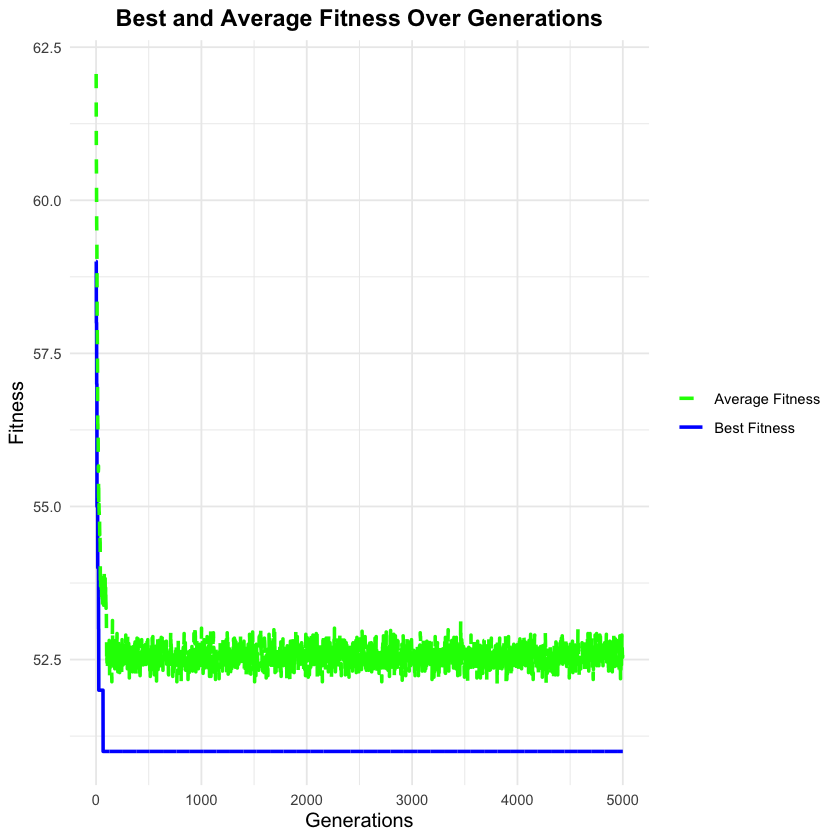

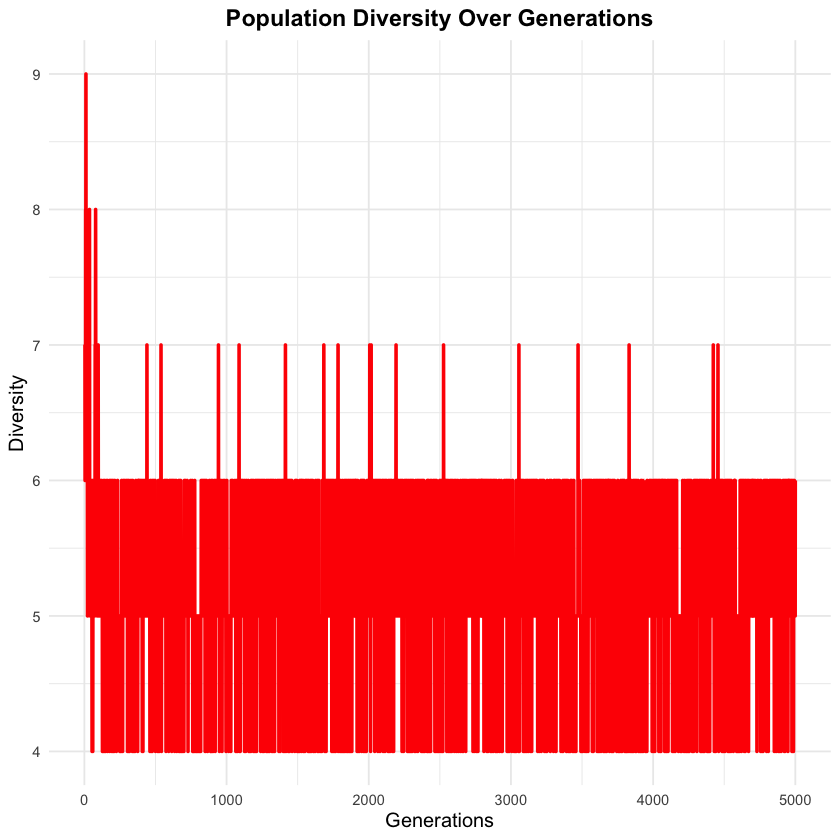

In [40]:
execution_time_no_diversity <- system.time({
  result_no_diversity <- GA(bp, 
                            population_size = 80, 
                            mutation_rate = 0.01, 
                            generations = generationsNumber, 
                            elite_ratio = 0.1, 
                            mutation_strategy = "adaptive", 
                            crossover_strategy = "two_point", 
                            selection_method = "tournament", 
                            tournament_size = 3, 
                            diversity_threshold = 0.9,
                            use_diversity = FALSE)
})

cat("Best Individual (no diversity):", result_no_diversity$best_individual, "\nBest Fitness (no diversity):", result_no_diversity$best_fitness, "\n")
cat("Execution Time (no diversity):", execution_time_no_diversity, "\n")

best_fitness_no_diversity <- result_no_diversity$best_fitness_over_time
average_fitness_no_diversity <- result_no_diversity$average_fitness_over_time
diversity_no_diversity <- result_no_diversity$diversity_over_time

plot_fitness(generationsNumber, best_fitness_no_diversity, average_fitness_no_diversity)
plot_diversity(generationsNumber, diversity_no_diversity)

Con función de agregar diversidad

Best Individual (with diversity): 104 65 40 81 19 44 98 116 49 48 39 97 42 111 18 74 14 66 115 24 7 103 106 63 54 13 89 90 108 51 33 15 6 60 41 30 45 107 69 43 21 93 68 56 77 31 99 57 91 61 100 16 11 9 95 17 52 109 86 32 34 25 76 84 27 20 119 53 35 22 80 28 83 36 26 110 79 58 37 112 12 62 50 102 71 47 78 82 2 38 92 85 23 113 64 8 73 96 70 1 118 72 88 120 5 67 75 4 59 55 10 87 46 117 101 94 114 3 29 105 
Best Fitness (with diversity): 51 
Execution Time (with diversity): 177.406 1.448 180.367 0 0 


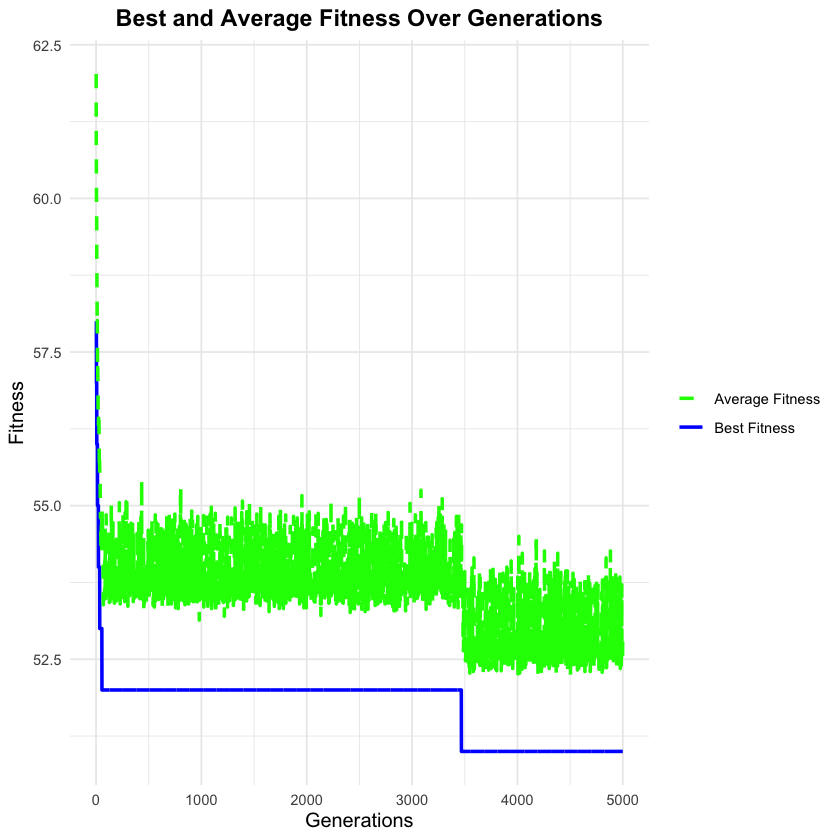

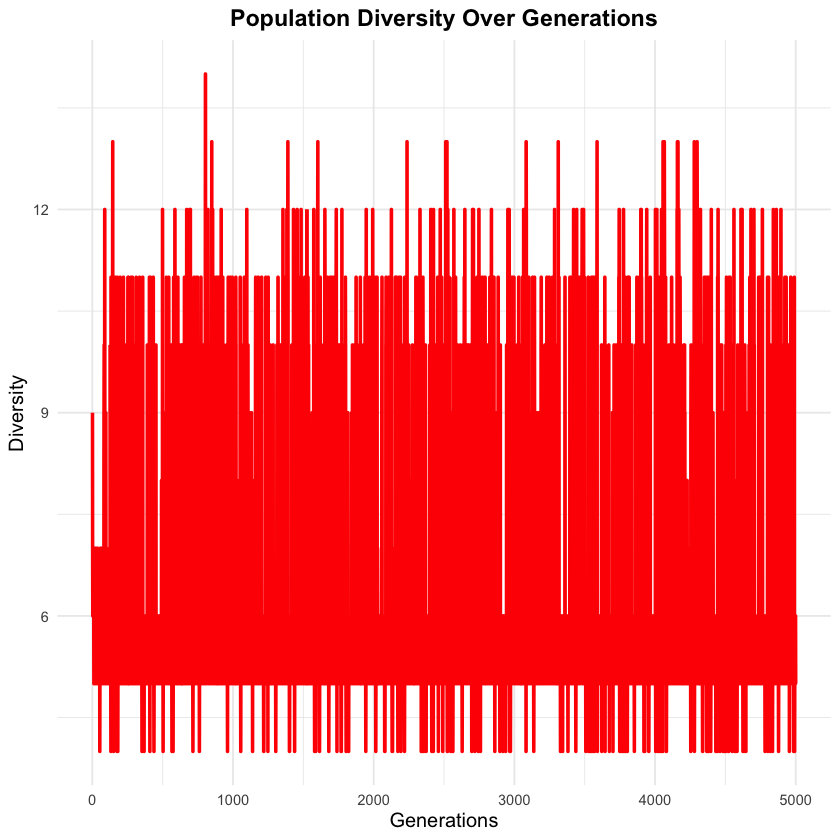

In [42]:
execution_time_with_diversity <- system.time({
  result_with_diversity <- GA(bp, 
                              population_size = 80, 
                              mutation_rate = 0.01, 
                              generations = generationsNumber, 
                              elite_ratio = 0.1, 
                              mutation_strategy = "adaptive", 
                              crossover_strategy = "two_point", 
                              selection_method = "tournament", 
                              tournament_size = 3, 
                              diversity_threshold = 0.9,
                              use_diversity = TRUE)
})

cat("Best Individual (with diversity):", result_with_diversity$best_individual, "\nBest Fitness (with diversity):", result_with_diversity$best_fitness, "\n")
cat("Execution Time (with diversity):", execution_time_with_diversity, "\n")

best_fitness_with_diversity <- result_with_diversity$best_fitness_over_time
average_fitness_with_diversity <- result_with_diversity$average_fitness_over_time
diversity_with_diversity <- result_with_diversity$diversity_over_time

plot_fitness(generationsNumber, best_fitness_with_diversity, average_fitness_with_diversity)
plot_diversity(generationsNumber, diversity_with_diversity)
beepr::beep()

### Prueba con variación de mutation method

"adaptive"
"swap"
"insertion"
"inversion" 


#### Swap

Best Individual: 69 94 59 95 107 113 100 96 34 73 91 10 109 44 9 92 53 13 3 63 23 36 80 103 48 110 105 98 120 101 6 57 68 76 55 49 28 82 60 111 12 45 43 89 97 86 46 37 104 1 32 77 29 108 31 42 11 8 118 22 39 51 83 87 81 119 93 66 64 70 5 65 27 78 116 84 56 88 114 85 75 41 62 7 21 4 106 15 24 30 58 72 61 79 14 19 2 50 71 102 74 47 38 54 112 16 90 67 25 18 26 33 35 20 99 40 117 17 115 52 
Best Fitness: 52 
Execution Time: 176.024 1.358 178.7 0 0 


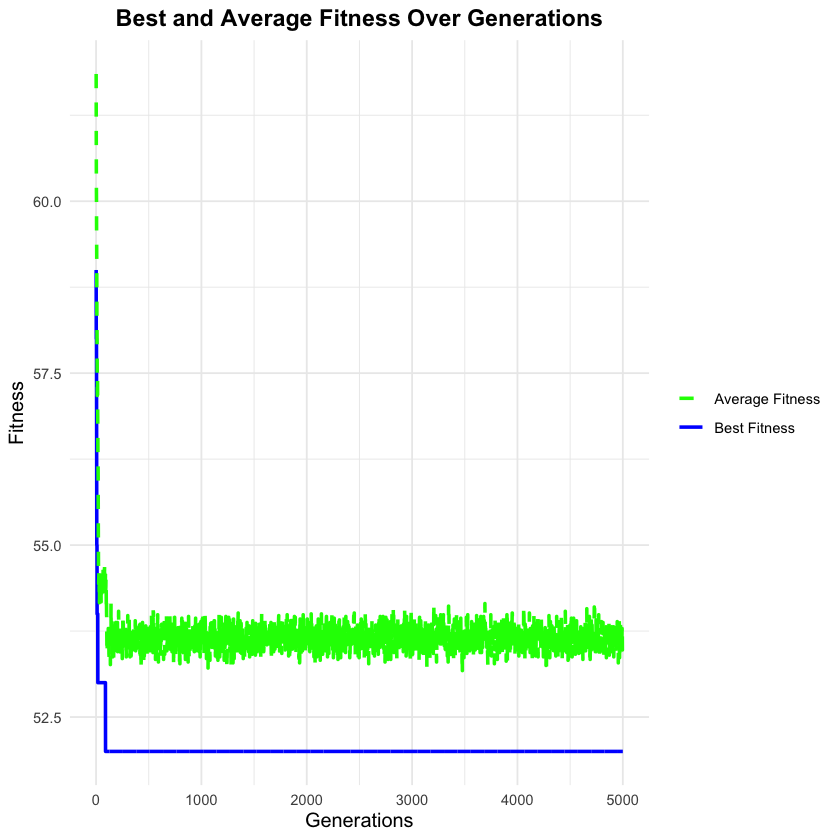

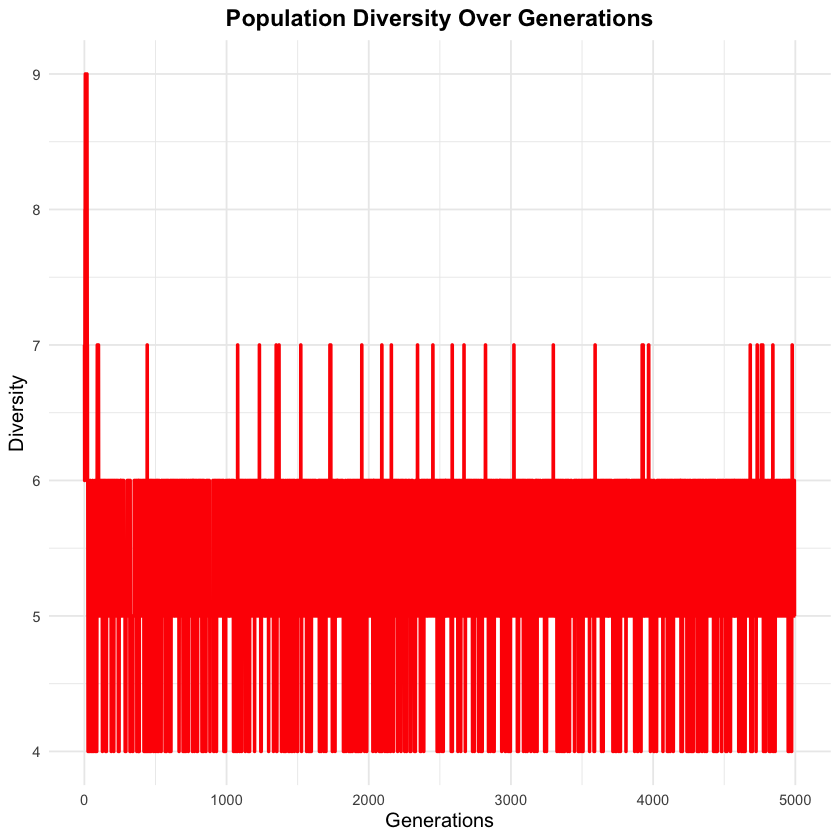

In [44]:
execution_time <- system.time({
  result <- GA(bp, 
               population_size = 80, 
               mutation_rate = 0.01, 
               generations = generationsNumber, 
               elite_ratio = 0.1, 
               mutation_strategy = "swap", 
               crossover_strategy = "two_point", 
               selection_method = "tournament", 
               tournament_size = 3, 
               diversity_threshold = 0.9)
})

cat("Best Individual:", result$best_individual, "\nBest Fitness:", result$best_fitness, "\n")
cat("Execution Time:", execution_time, "\n")

best_fitness <- result$best_fitness_over_time
average_fitness <- result$average_fitness_over_time
diversity <- result$diversity_over_time

plot_fitness(generationsNumber, best_fitness, average_fitness)
plot_diversity(generationsNumber, diversity)
beepr::beep()

#### Insertion

Best Individual: 96 85 49 14 101 65 118 115 63 70 78 120 64 24 97 13 119 58 28 39 30 40 26 77 60 99 48 88 86 43 23 9 74 103 35 5 16 98 76 69 83 57 61 79 91 10 113 80 4 110 32 68 56 84 114 66 36 100 107 82 11 46 116 72 67 90 54 20 109 41 18 95 38 59 112 45 22 29 111 15 6 37 55 25 44 50 52 51 33 8 104 106 27 87 12 73 89 2 21 53 92 19 42 75 117 108 47 94 17 71 105 93 62 3 31 1 81 7 34 102 
Best Fitness: 51 
Execution Time: 179.847 1.523 183.547 0 0 


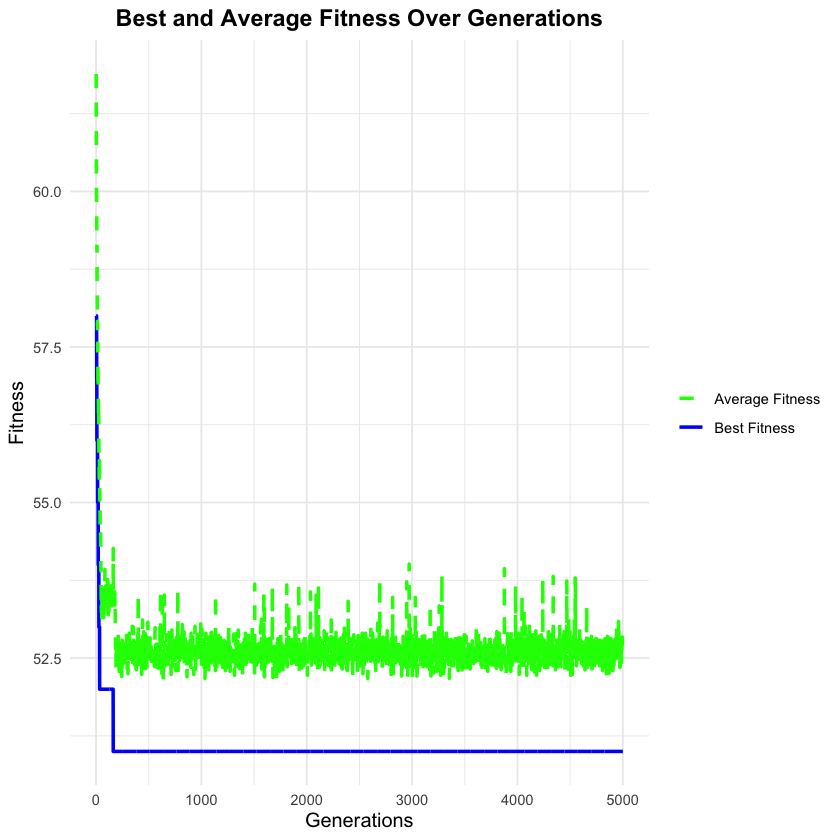

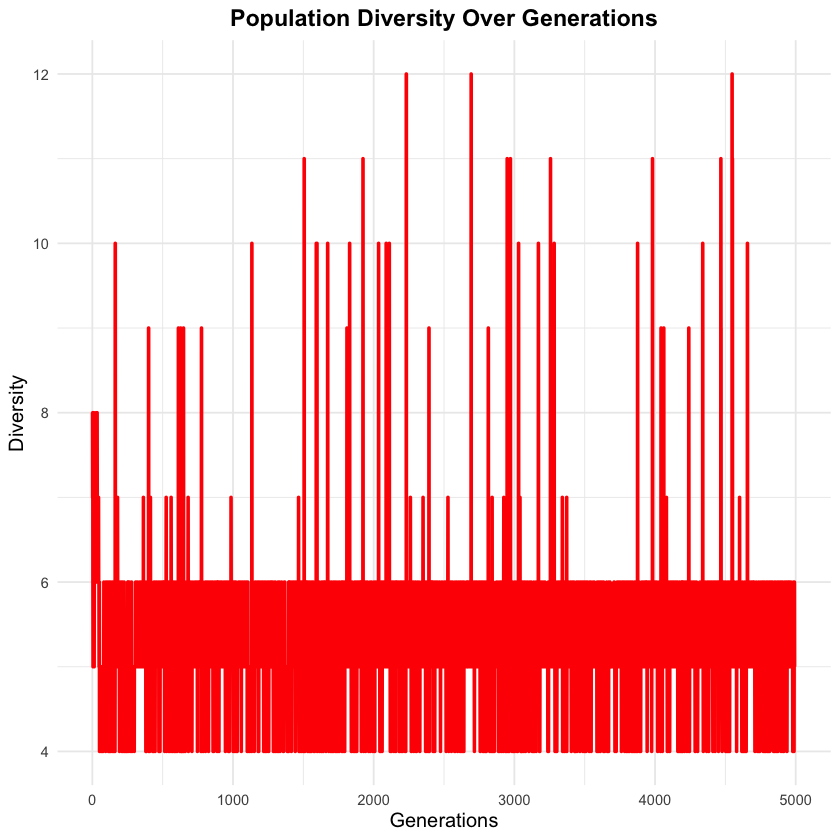

In [45]:
execution_time <- system.time({
  result <- GA(bp, 
               population_size = 80, 
               mutation_rate = 0.01, 
               generations = generationsNumber, 
               elite_ratio = 0.1, 
               mutation_strategy = "insertion", 
               crossover_strategy = "two_point", 
               selection_method = "tournament", 
               tournament_size = 3, 
               diversity_threshold = 0.9)
})

cat("Best Individual:", result$best_individual, "\nBest Fitness:", result$best_fitness, "\n")
cat("Execution Time:", execution_time, "\n")

best_fitness <- result$best_fitness_over_time
average_fitness <- result$average_fitness_over_time
diversity <- result$diversity_over_time

plot_fitness(generationsNumber, best_fitness, average_fitness)
plot_diversity(generationsNumber, diversity)
beepr::beep()

#### Inversion

Best Individual: 68 21 14 82 8 103 5 56 69 85 95 72 28 119 113 63 62 89 74 73 29 118 33 18 102 48 76 40 98 16 15 105 110 78 38 60 111 51 3 71 52 83 96 99 17 4 58 114 92 25 86 10 120 34 19 70 108 57 97 24 91 75 13 80 30 94 7 112 117 90 50 59 20 104 44 109 11 116 53 12 43 45 26 2 1 47 23 93 41 27 36 77 81 87 31 55 106 61 65 84 49 22 9 79 88 39 32 42 67 54 35 115 6 66 46 107 100 64 101 37 
Best Fitness: 52 
Execution Time: 181.72 1.694 187.004 0 0 


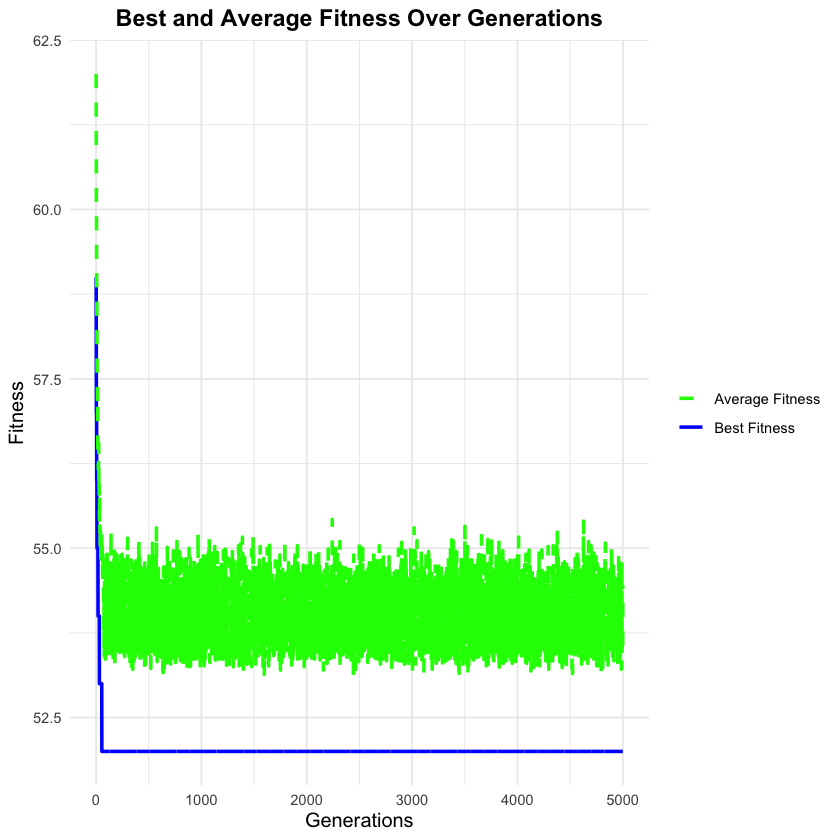

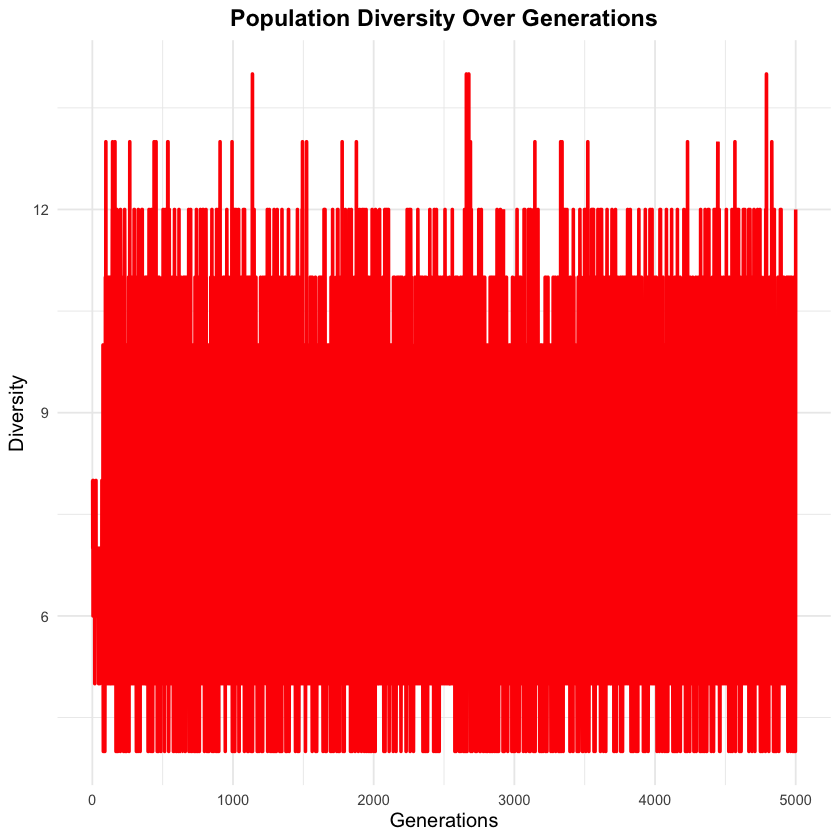

In [46]:
execution_time <- system.time({
  result <- GA(bp, 
               population_size = 80, 
               mutation_rate = 0.01, 
               generations = generationsNumber, 
               elite_ratio = 0.1, 
               mutation_strategy = "inversion", 
               crossover_strategy = "two_point", 
               selection_method = "tournament", 
               tournament_size = 3, 
               diversity_threshold = 0.9)
})

cat("Best Individual:", result$best_individual, "\nBest Fitness:", result$best_fitness, "\n")
cat("Execution Time:", execution_time, "\n")

best_fitness <- result$best_fitness_over_time
average_fitness <- result$average_fitness_over_time
diversity <- result$diversity_over_time

plot_fitness(generationsNumber, best_fitness, average_fitness)
plot_diversity(generationsNumber, diversity)
beepr::beep()

#### Adaptive

Best Individual: 70 28 58 10 115 8 61 32 44 41 30 56 91 66 117 27 86 1 59 9 48 88 78 114 101 68 46 108 53 21 25 7 5 112 23 102 33 22 110 64 47 26 71 19 84 67 72 18 15 13 16 120 96 42 20 104 83 76 85 2 52 74 29 118 17 49 11 35 6 119 43 116 95 75 81 3 39 60 92 106 98 87 73 89 90 103 51 24 37 38 99 36 62 94 12 57 65 14 50 54 55 40 111 97 77 82 93 107 45 113 63 69 4 105 80 109 100 31 34 79 
Best Fitness: 52 
Execution Time: 181.52 1.665 185.242 0 0 


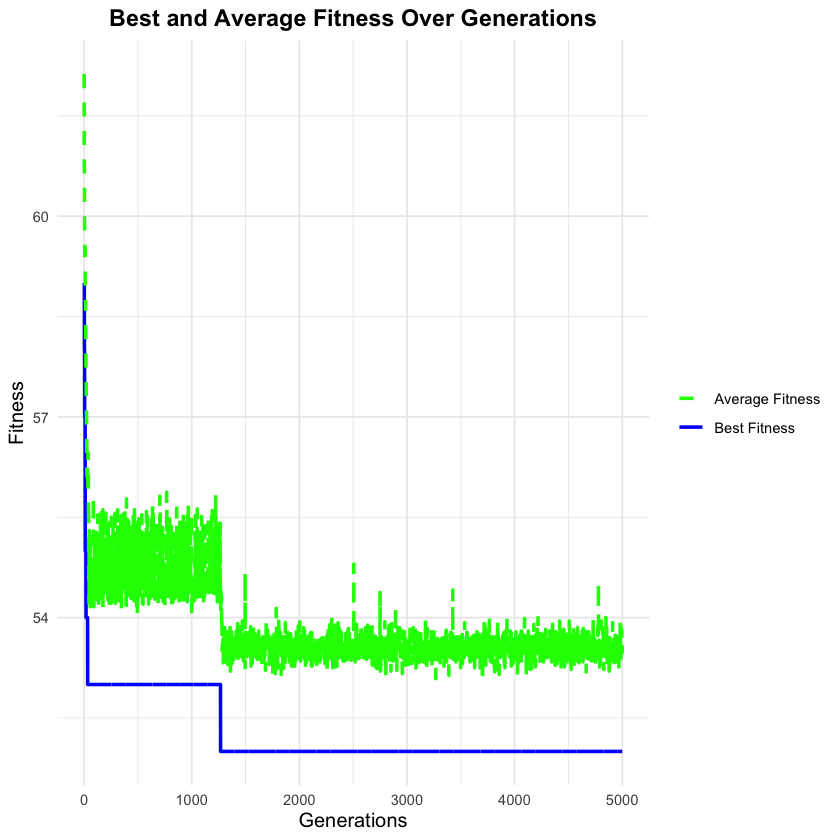

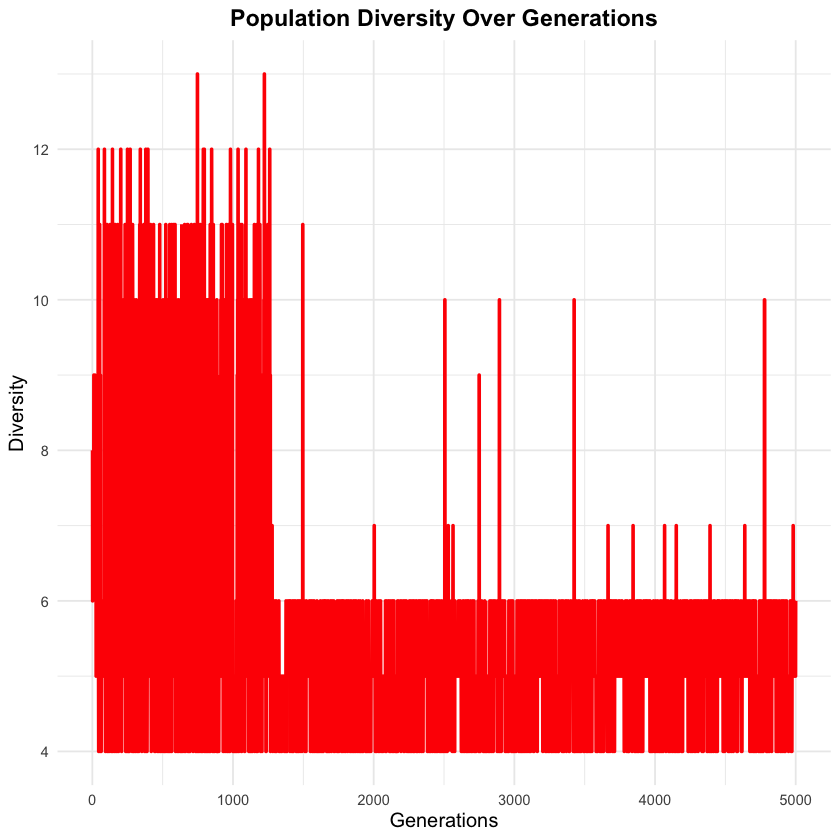

In [48]:
execution_time <- system.time({
  result <- GA(bp, 
               population_size = 80, 
               mutation_rate = 0.01, 
               generations = generationsNumber, 
               elite_ratio = 0.1, 
               mutation_strategy = "adaptive", 
               crossover_strategy = "two_point", 
               selection_method = "tournament", 
               tournament_size = 3, 
               diversity_threshold = 0.9)
})

cat("Best Individual:", result$best_individual, "\nBest Fitness:", result$best_fitness, "\n")
cat("Execution Time:", execution_time, "\n")

best_fitness <- result$best_fitness_over_time
average_fitness <- result$average_fitness_over_time
diversity <- result$diversity_over_time

plot_fitness(generationsNumber, best_fitness, average_fitness)
plot_diversity(generationsNumber, diversity)
beepr::beep()

### Prueba con variación de crossover strategy

#### One point

Best Individual: 75 65 37 72 8 47 85 64 76 16 119 80 4 44 28 82 2 111 32 35 19 22 109 101 24 89 58 23 43 9 92 88 21 56 95 46 55 83 100 62 54 29 33 69 25 1 51 79 116 57 108 30 114 99 91 112 11 113 26 87 15 68 74 20 7 104 18 94 71 14 73 39 48 10 63 81 42 78 115 52 106 38 60 49 50 77 31 45 98 41 6 13 103 86 84 117 34 97 90 118 36 59 40 3 107 66 70 67 61 102 12 105 53 96 93 110 5 120 27 17 
Best Fitness: 53 
Execution Time: 118.3 1.089 121.635 0 0 


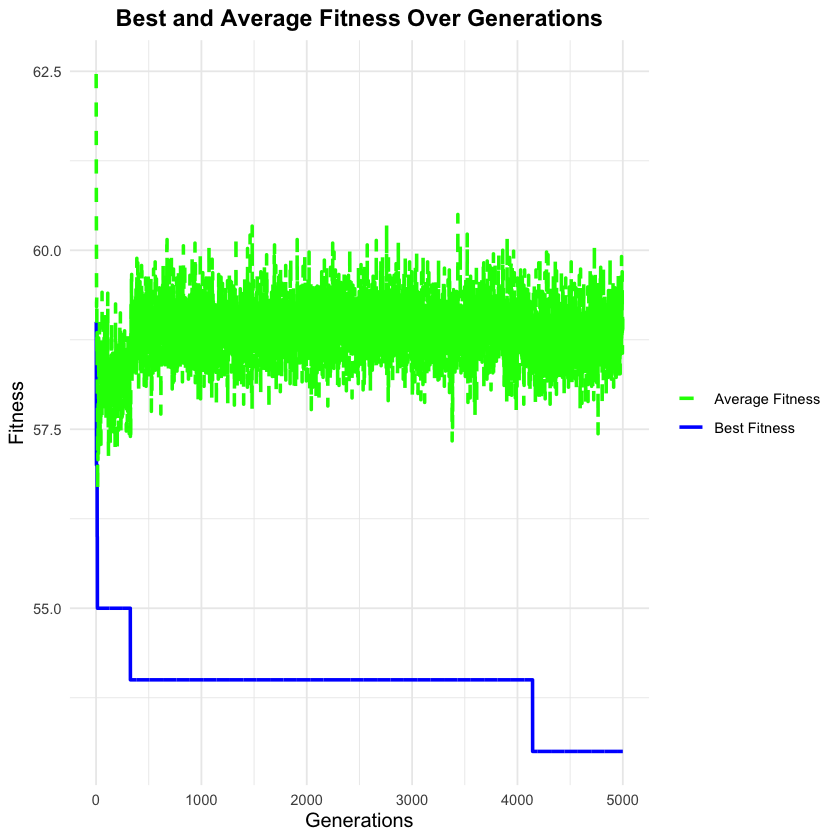

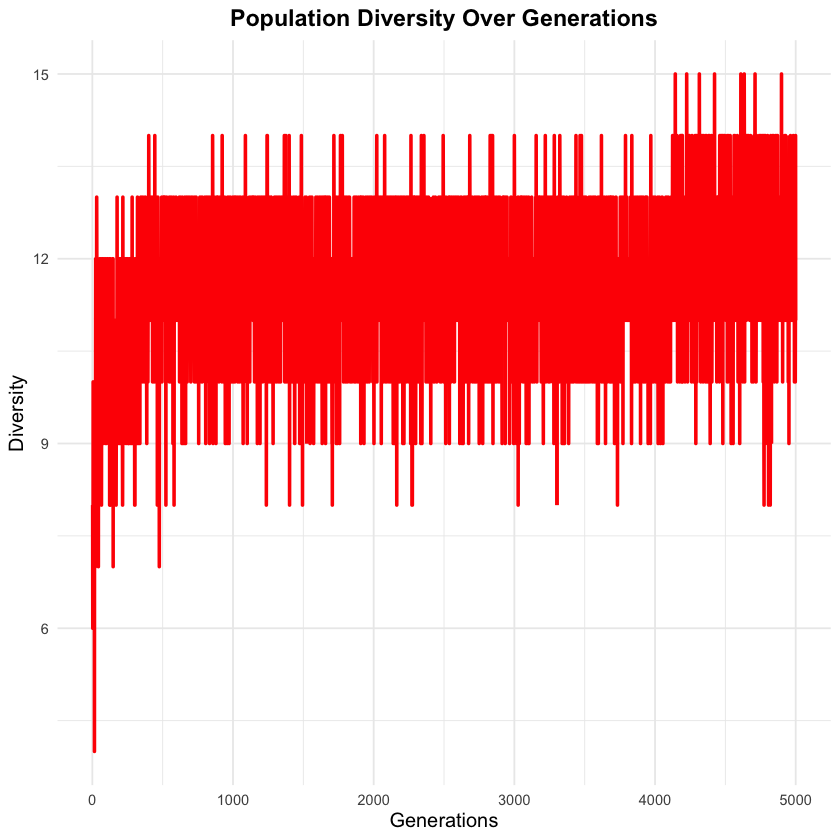

In [50]:
execution_time <- system.time({
  result <- GA(bp, 
               population_size = 80, 
               mutation_rate = 0.01, 
               generations = generationsNumber, 
               elite_ratio = 0.1, 
               mutation_strategy = "adaptive", 
               crossover_strategy = "one_point", 
               selection_method = "tournament", 
               tournament_size = 3, 
               diversity_threshold = 0.9)
})

cat("Best Individual:", result$best_individual, "\nBest Fitness:", result$best_fitness, "\n")
cat("Execution Time:", execution_time, "\n")

best_fitness <- result$best_fitness_over_time
average_fitness <- result$average_fitness_over_time
diversity <- result$diversity_over_time

plot_fitness(generationsNumber, best_fitness, average_fitness)
plot_diversity(generationsNumber, diversity)
beepr::beep()

#### Two Point

Best Individual: 97 46 58 70 39 88 73 52 57 65 44 78 107 21 111 23 93 80 61 42 118 16 85 106 75 67 84 4 66 24 43 48 14 29 90 50 110 112 45 56 76 41 31 63 71 77 26 33 7 15 98 91 82 10 13 68 89 25 79 19 115 30 102 53 54 99 12 18 36 64 100 32 103 20 38 34 6 92 119 51 86 114 40 37 17 116 101 94 95 96 120 104 49 8 2 62 1 74 81 47 11 27 72 83 105 87 3 59 69 5 109 28 22 60 108 35 55 117 113 9 
Best Fitness: 52 
Execution Time: 177.875 1.382 181.457 0 0 


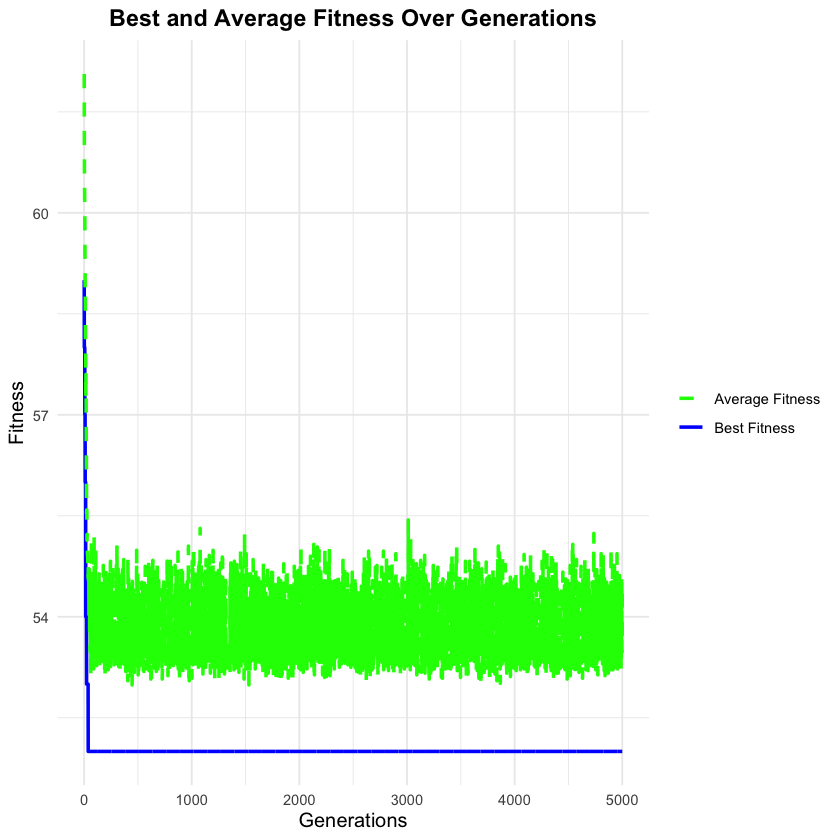

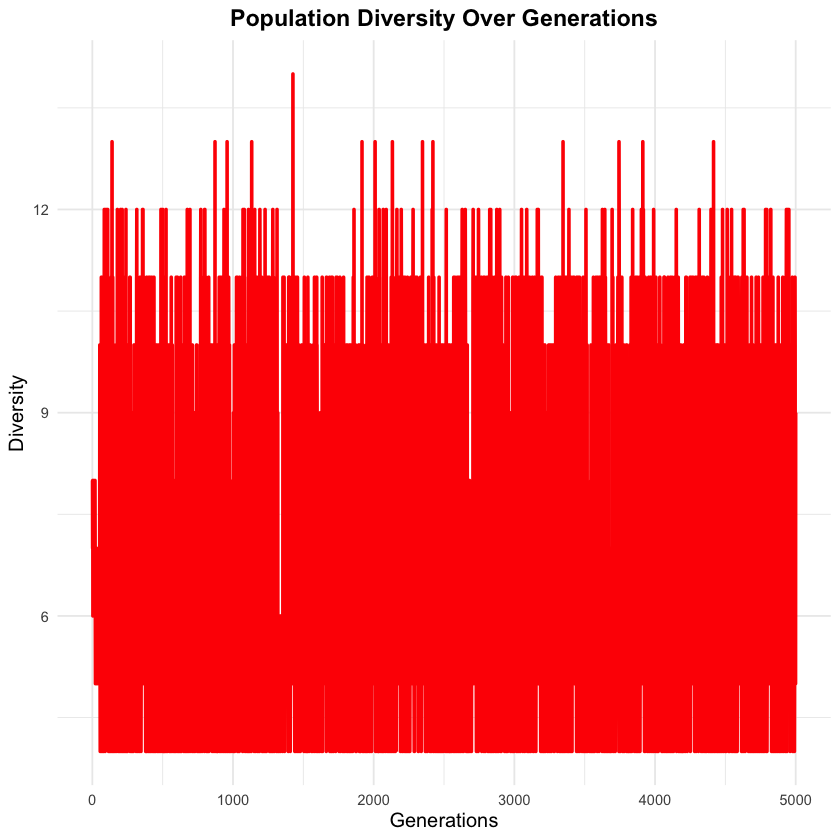

In [51]:
execution_time <- system.time({
  result <- GA(bp, 
               population_size = 80, 
               mutation_rate = 0.01, 
               generations = generationsNumber, 
               elite_ratio = 0.1, 
               mutation_strategy = "adaptive", 
               crossover_strategy = "two_point", 
               selection_method = "tournament", 
               tournament_size = 3, 
               diversity_threshold = 0.9)
})

cat("Best Individual:", result$best_individual, "\nBest Fitness:", result$best_fitness, "\n")
cat("Execution Time:", execution_time, "\n")

best_fitness <- result$best_fitness_over_time
average_fitness <- result$average_fitness_over_time
diversity <- result$diversity_over_time

plot_fitness(generationsNumber, best_fitness, average_fitness)
plot_diversity(generationsNumber, diversity)
beepr::beep()

#### Uniform

Best Individual: 88 61 85 93 24 6 67 74 4 52 36 53 43 79 112 86 16 1 5 29 78 57 90 18 107 80 54 58 103 100 113 84 48 17 99 104 39 9 72 106 38 76 15 111 55 116 87 40 31 26 12 3 108 37 8 95 68 115 13 73 41 109 66 70 20 110 98 7 89 25 28 10 96 27 69 51 60 19 46 34 23 42 82 101 119 11 44 94 92 102 83 45 105 62 30 47 56 33 120 59 21 35 2 97 14 63 65 50 118 32 117 49 77 81 64 75 114 22 71 91 
Best Fitness: 52 
Execution Time: 242.043 6.645 250.117 0 0 


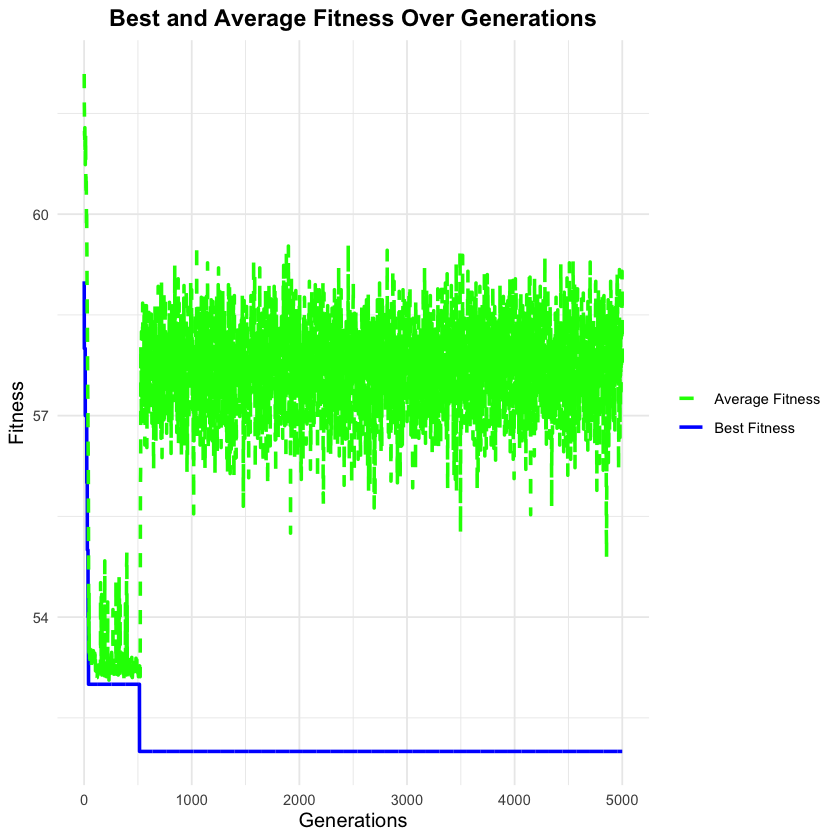

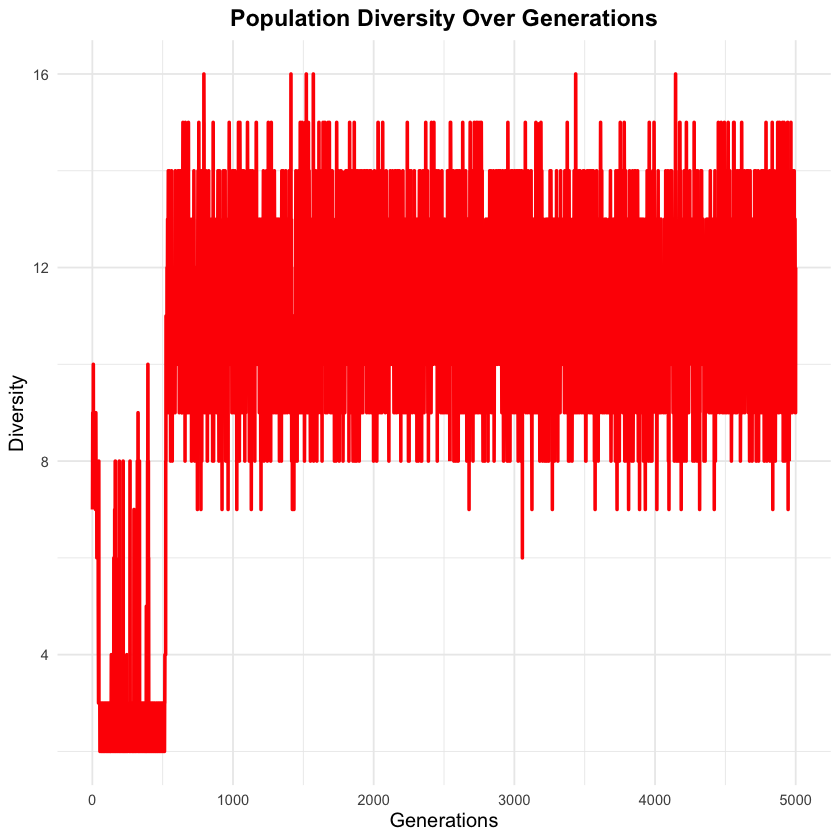

In [52]:
execution_time <- system.time({
  result <- GA(bp, 
               population_size = 80, 
               mutation_rate = 0.01, 
               generations = generationsNumber, 
               elite_ratio = 0.1, 
               mutation_strategy = "adaptive", 
               crossover_strategy = "uniform", 
               selection_method = "tournament", 
               tournament_size = 3, 
               diversity_threshold = 0.9)
})

cat("Best Individual:", result$best_individual, "\nBest Fitness:", result$best_fitness, "\n")
cat("Execution Time:", execution_time, "\n")

best_fitness <- result$best_fitness_over_time
average_fitness <- result$average_fitness_over_time
diversity <- result$diversity_over_time

plot_fitness(generationsNumber, best_fitness, average_fitness)
plot_diversity(generationsNumber, diversity)
beepr::beep()